# Visual Question Answering (VQA) Implementation

This notebook serves as the main implementation for the Visual Question Answering (VQA) project. It includes all the necessary code for data loading, model training, evaluation, and demonstration.


### Initial Setup

This code cell contains the initial setup steps required before implementing the Visual Question Answering (VQA) system. It includes:

- Importing necessary libraries such as PyTorch, NLTK, and PIL.
- Downloading the WordNet dataset using NLTK.
- Importing additional modules and functions from the project-specific `datasets` module.
- Importing NumPy for numerical computations.
- Importing Pandas for data manipulation.
- Importing modules for file and directory operations (os, re, json).

### Dataset 
MMDP-VQA (https://www.kaggle.com/datasets/anantkacholia/mmdp-vqa)

These setup steps ensure that all required libraries and resources are available for subsequent stages of the implementation.


In [44]:
import torch, nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.corpus import wordnet
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import pandas as pd
import os, re, json

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### WordNet Data Download

This code cell checks if the WordNet dataset is available locally. If not, it downloads and extracts the dataset from a ZIP file. Here's what it does:


In [3]:
if not os.path.exists('/usr/share/nltk_data/corpora/wordnet'):
    !unzip '/usr/share/nltk_data/corpora/wordnet.zip' -d '/usr/share/nltk_data/corpora'

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

### Setting Input and Image Paths

This code cell defines the input path and the path to the images directory within the Kaggle dataset. Here's what it does:


In [62]:
input_path = '/kaggle/input/mmdp-vqa'
images_path = os.path.join(input_path, 'images')

### Importing PyTorch and TorchVision Modules

This code cell imports modules from the PyTorch and TorchVision libraries. Here's a summary of what it does:

- It imports the `models` module from the `torchvision` library, which contains pre-trained models for image classification, such as VGG, ResNet, and AlexNet.
- It imports the entire `torchvision` library, which provides utilities for image and video datasets, pre-trained models, and image transformations.
- It imports the `nn` module from the `torch` library, which contains neural network layers, loss functions, and other utilities for building and training neural networks.

These imports are necessary for building the VQA model architecture and performing operations on tensors and neural network layers.


In [63]:
from torchvision import models
import torchvision
from torch import nn

### VQA Model Architecture

This code cell defines the architecture of the Visual Question Answering (VQA) model using PyTorch's `nn.Module` class. Here's a summary of what it does:

- It defines a class called `VQAModel` that inherits from the `nn.Module` class.
- The constructor (`__init__` method) initializes the VQA model architecture. It consists of the following components:
  - Image embedding: The model uses a pre-trained VGG16 model for extracting features from input images. The fully connected layers of the VGG16 model are removed and replaced with a custom fully connected layer (`fc1`) to reduce the output dimensionality to 1024.
  - Text embedding: The model uses an embedding layer to convert input word indices into dense vectors of fixed size (`embedding_size`).
  - LSTM layer: A bidirectional LSTM (Long Short-Term Memory) layer processes the embedded text features to capture the sequential dependencies in the input text.
  - Fully connected layer (`fc2`): This layer linearly transforms the LSTM output to a lower-dimensional space with a dimensionality of 1024.
  - Classifier: The final fully connected layer (`classifier`) maps the concatenated image and text features to the output space, which contains the predicted classes for the VQA task.
- The `forward` method defines the forward pass of the model. It takes input images and text prompts as inputs and computes the output logits for each class.

This architecture combines visual and textual information to predict answers to questions about images in the VQA task.
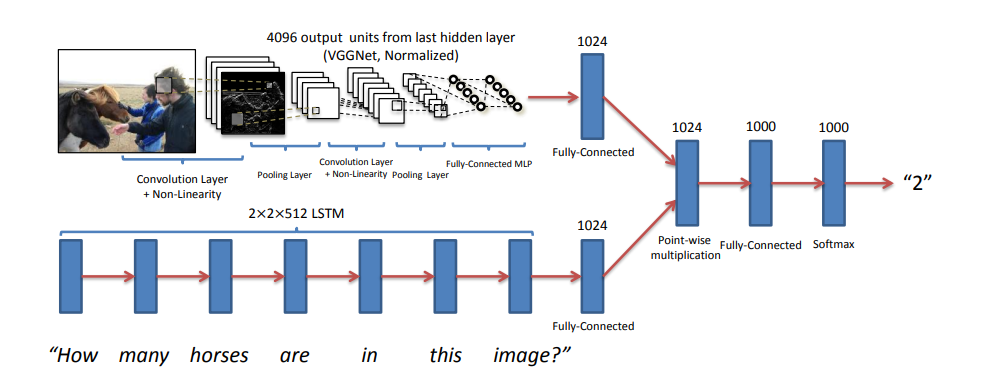

In [64]:
class VQAModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(VQAModel, self).__init__()

        self.image_embedding = torchvision.models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
        self.image_embedding.classifier = self.image_embedding.classifier[:-1]
        self.fc1 = nn.Linear(4096, 1024)
        
        
        self.vocab_size = kwargs.pop("vocab_size", 2048)
        self.embedding_size = kwargs.pop("embedding_size", 300)
        self.hidden_size = kwargs.pop("hidden_size", 1024)
        self.lstm_layers = kwargs.pop("lstm_layers", 1)
        self.classes = kwargs.pop("classes", 1024)
        self.sequence_length = kwargs.pop("sequence_length", 30)
        
        self.text_embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = nn.LSTM(input_size = self.embedding_size, hidden_size = self.hidden_size, num_layers  = self.lstm_layers, batch_first = True)
        self.fc2 = nn.Linear(self.hidden_size * self.sequence_length, 1024)
        
        self.classifier = nn.Linear(1024, self.classes)
        
    def forward(self, images, prompts):
        image_features = self.image_embedding(images) # (batch_size, 3, 224, 224)
        image_features = self.fc1(image_features) # (batch_size, 4096)
        
        text_features = self.text_embedding(prompts) # (batch_size, max_length, embedding_size)
        text_features, (_, _) = self.lstm(text_features) # (batch_size, max_length, hidden_size)
        
        text_features = text_features.contiguous().view(text_features.size(0), -1)

        text_features = self.fc2(text_features) # (batch_size, max_length, 1024)
        
        features = torch.mul(image_features, text_features)
        features = self.classifier(features)
        
        return features

### WordNet Wu-Palmer Similarity Function

This code cell defines a function called `wups` that calculates the Wu-Palmer Similarity (Wu-Palmer relatedness measure) between two input words or synsets (WordNet entities). Here's a summary of what it does:

- The `wups` function takes two inputs, `wa` and `wb`, which can be either strings representing words or synsets (WordNet entities).
- If the inputs are strings, the function converts them to synsets using NLTK's WordNet interface.
- The function then computes the Wu-Palmer similarity score between each pair of synsets (one from `wa` and one from `wb`) using the `wup_similarity` method provided by NLTK's WordNet interface.
- The final similarity score is the maximum similarity score among all pairs of synsets.
- The function returns the computed similarity score.

The Wu-Palmer similarity measure is a metric used to quantify the similarity between concepts or entities based on their hierarchical structure in WordNet. It calculates the similarity between synsets by considering their least common subsumer (LCS) and the depths of the synsets in the WordNet hierarchy.


In [65]:
def wups(wa, wb):
    if type(wa) == str:
        wa = wordnet.synsets(wa)
        
    if type(wb) == str:
        wb = wordnet.synsets(wb)
        
    score = 0
    
    for i in wa:
        for j in wb:
            x = i.wup_similarity(j)
            if x is not None: score = max(score, x)

    return score

### Utility Functions

This code cell contains utility functions used for loading and preprocessing statements, splitting dataframes, and generating the answer space. Here's a brief description of each function:

#### 1. `load_statements(file)`
   - This function loads statements from a file and creates a DataFrame containing questions, answers, and image IDs.
   - It removes redundant patterns from the questions using a regular expression pattern defined as `__redundants_pattern`.
   - Returns the DataFrame.

#### 2. `get_answer_space(df: pd.DataFrame) -> list`
   - This function generates the answer space by extracting unique answers from the DataFrame.
   - Returns a list containing the answer space.

#### 3. `split_df(df, test_size=0.2, train_out=None, test_out=None)`
   - This function splits a DataFrame into training and testing sets.
   - The `test_size` parameter specifies the proportion of the dataset to include in the test split.
   - It optionally saves the split datasets to CSV files specified by `train_out` and `test_out`.
   - Returns the training and testing DataFrames.


In [66]:
__redundants_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

def load_statements(file):
    with open(file, 'r') as fp:
        statements = fp.read().splitlines()
        
    df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})
    for i in range(0, len(statements), 2):
        img_id = __redundants_pattern.findall(statements[i])[0][3]
        question = statements[i].replace(__redundants_pattern.findall(statements[i])[0][0], "")
        record = {
            "question": question,
            "answer": statements[i+1],
            "image_id": img_id,
        }
        df = df.append(record, ignore_index=True)
    
    return df

def get_answer_space(df: pd.DataFrame) -> list:
    answer_space = []
    for ans in df.answer.to_list():
        answer_space += [ans] if "," not in ans else ans.replace(" ", "").split(",")
        
    answer_space = list(set(answer_space))
    answer_space.sort()
    
    return answer_space

def split_df(df, test_size = 0.2, train_out = None, test_out = None):
    train_df, test_df = train_test_split(df, test_size=test_size)

    if train_out is not None:
        train_df.to_csv(train_out, index=False)
    
    if test_out is not None:
        test_df.to_csv(test_out, index=False)
        
    return train_df, test_df

### File Paths

This code cell defines file paths used for loading training and testing data. The `data_files` dictionary contains two keys:

#### 1. `"train"`
   - Specifies the file path for the training data CSV file.
   - It is constructed by joining the `input_path` variable with the filename `'train.csv'`.

#### 2. `"test"`
   - Specifies the file path for the testing data CSV file.
   - It is constructed by joining the `input_path` variable with the filename `'test.csv'`.


In [67]:
data_files = {
    "train": os.path.join(input_path, 'train.csv'),
    "test": os.path.join(input_path, 'test.csv')
}

In [68]:
train_df, test_df = pd.read_csv(data_files['train']), pd.read_csv(data_files['test'])

In [69]:
train_df

,question,answer,image_id
0,what is the green object on the floor,basket,image519
1,what is at the left of the candelabra,window,image1324
2,what is on the drawer,towel,image573
3,what is to right of bed,window,image515
4,what is behind the tissue roll,bottle_of_liquid,image820
...,...,...,...
9969,what is the object close to the sink,faucet,image682
9970,how many lights are on,3,image22
9971,what are found on the table,"lamp, tissue_box",image1094
9972,what is to the left of the box,shelves,image181


### Preprocessing Text Data

This code cell preprocesses the text data by tokenizing the questions and answers, and creating dictionaries to map words and answers to indices.

#### 1. Word Indexing:
   - Two dictionaries are created: `word_2_idx` and `idx_2_word`.
   - These dictionaries map words to their corresponding indices and vice versa.
   - Each unique word in the questions is assigned a unique index.
   - The same process is repeated for both the training and testing datasets.

#### 2. Answer Indexing:
   - Two dictionaries are created: `answer_2_idx` and `idx_2_answer`.
   - These dictionaries map answers to their corresponding indices and vice versa.
   - Each unique answer in the dataset is assigned a unique index.
   - The same process is repeated for both the training and testing datasets.

#### 3. Saving Dictionaries to Files:
   - The dictionaries containing word and answer indices are saved to text files named `'dictionaries.txt'` and `'answers-index.txt'`, respectively.

#### 4. Additional Information:
   - `max_length_question`: The maximum length of the questions after tokenization.
   - `answer_space_length`: The total number of unique answers in the dataset.
   - `words_length`: The total number of unique words in the dataset.

Note: The code also adjusts the `max_length_question` parameter for potential padding during training.


In [70]:
word_2_idx, idx_2_word = {}, {}
answer_2_idx, idx_2_answer = {}, {}
max_length_question = 0
words_counter, answer_counter = 0, 0

for line in train_df['question']:
    line = word_tokenize(line.lower())
    max_length_question = max(max_length_question, len(line))
    for i in line:
        if i not in word_2_idx:
            word_2_idx[i], idx_2_word[words_counter] = words_counter, i
            words_counter += 1

for line in test_df['question']:
    line = word_tokenize(line.lower())
    max_length_question = max(max_length_question, len(line))
    for i in line:
        if i not in word_2_idx:
            word_2_idx[i], idx_2_word[words_counter] = words_counter, i
            words_counter += 1
        
for line in train_df['answer']:
    line = word_tokenize(line.lower())
    for i in line:
        if i not in answer_2_idx:
            answer_2_idx[i], idx_2_answer[answer_counter] = answer_counter, i
            answer_counter += 1
        
for line in test_df['answer']:
    line = word_tokenize(line.lower())
    for i in line:
        if i not in answer_2_idx:
            answer_2_idx[i], idx_2_answer[answer_counter] = answer_counter, i
            answer_counter += 1


words = [None] * len(word_2_idx)

for word, index in word_2_idx.items():
    words[index] = word

answers = [None] * len(answer_2_idx)
for word, index in answer_2_idx.items():
    answers[index] = word
    
with open('dictionaries.txt', 'w') as fp:
    fp.write('\n'.join(words))
    
with open('answers-index.txt', 'w') as fp:
    fp.write('\n'.join(answers))
    

max_length_question = max_length_question * 4 // 3
answer_space_length = len(answer_2_idx)
words_length = len(word_2_idx)

### Data Conversion Functions

This cell defines functions for converting questions and answers into numerical representations suitable for the model.

1. `convert_question(s: str) -> List[int]`:
   - Converts a question string `s` to a list of integers representing word indices.
   - Padding ensures uniform length based on the maximum question length.

2. `convert_answer(s: str) -> List[int]`:
   - Converts an answer string `s` to a binary vector.
   - Each position corresponds to an answer index, set to 1 if present, 0 otherwise.

These functions prepare textual data for model input efficiently.


In [71]:
def convert_question(s: str):
    res = [word_2_idx.get(item, len(word_2_idx)) for item in word_tokenize(s.lower())]
    res += [len(word_2_idx)] * (max_length_question - len(res))
    return res

def convert_answer(s: str):
    answer = [0] * (answer_space_length + 1)
    for idx in [answer_2_idx.get(item, len(word_2_idx)) for item in word_tokenize(s.lower())]:
        answer[idx] = 1
    return answer

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Model Initialization

This cell initializes the Visual Question Answering (VQA) model.

- **Parameters**:
  - `vocab_size`: Vocabulary size for word embeddings.
  - `sequence_length`: Maximum length of the input sequence.
  - `hidden_size`: Size of the hidden LSTM layer.
  - `lstm_layers`: Number of LSTM layers.
  - `classes`: Number of output classes for classification.
  - `embedding_size`: Size of the word embedding vectors.

The model is then transferred to the specified device (CPU or GPU) for computation.


In [73]:
model = VQAModel(
    vocab_size = words_length + 1, # +1 for the mistake
    sequence_length = max_length_question, 
    hidden_size = 512, 
    lstm_layers = 2, 
    classes = answer_space_length + 1, # +1 for the mistake
    embedding_size = 512
)

model = model.to(device)

### QADataset Class

This class represents a PyTorch dataset for the Visual Question Answering (VQA) task.

#### Constructor:
- **Parameters**:
  - `dataset`: The dataset containing image-question-answer tuples.
  - `transform`: Optional. The transformation to be applied to the images.
  - `question_preprocess`: Optional. A function to preprocess the questions.
  - `answer_preprocess`: Optional. A function to preprocess the answers.
  - `image_root`: The root directory containing the images.
- **Attributes**:
  - `images_path`: List of paths to the image files.
  - `question`: List of questions.
  - `answer`: List of answers.

#### Methods:
- `load()`: Loads the images, questions, and answers from the dataset.
- `__len__()`: Returns the total number of samples in the dataset.
- `max_length()`: Returns the maximum length of the questions in the dataset.
- `__getitem__(index)`: Retrieves the image, question, and answer at the specified index.



In [75]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, *args, **kwargs):
        self.dataset = dataset
        self.transform, self.question_preprocess, self.answer_preprocess = \
            kwargs.pop("transform", None), kwargs.pop("question_preprocess", None), \
            kwargs.pop("answer_preprocess", None)
        self.image_root = kwargs.pop("image_root", None)
        assert self.image_root is not None, "Image root is not defined"
        self.images_path, self.question, self.answer = self.load()
        self.to_tensor = torchvision.transforms.ToTensor()
        
    def load(self):
        images_path, question, answer = [], [], []
        
        for item in self.dataset:
            images_path += [item["image_id"]]
            question += [item["question"]]
            answer += [item["answer"]]
            
        images_path = [os.path.join(self.image_root, f'{id}.png') for id in images_path]

        if self.question_preprocess:
            question = [self.question_preprocess(item) for item in question]

        if self.answer_preprocess:
            answer = [self.answer_preprocess(item) for item in answer]
                    
        return images_path, question, answer
    
    def __len__(self):
        return len(self.images_path)
    
    def max_length(self):
        return self.max_lengthmax
    
    def __getitem__(self, index):
        image_data = Image.open(self.images_path[index]).convert("RGB")
        
        if self.transform:
            image_data = self.transform(image_data)
            
        if type(image_data) is not torch.Tensor:
            image_data = self.to_tensor(image_data)
                
        return image_data, torch.tensor(self.question[index], dtype = torch.long), torch.tensor(self.answer[index], dtype = torch.float)


In [76]:
pre_load_dataset = load_dataset(
    "csv",
    data_files = data_files
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-95edc98029211799/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Data Loading

This section loads the training and validation datasets for the VQA task.

#### Training Dataset
- Dataset: `pre_load_dataset['train']`
- Transformations: Resize, Random Crop, Convert to Tensor, Normalize
- Question Preprocessing: Convert to Indices
- Answer Preprocessing: One-hot Encoding
- Batch Size: 32
- Shuffle: True
- Workers: 2

#### Validation Dataset
- Dataset: `pre_load_dataset['test']`
- Transformations: Resize, Convert to Tensor, Normalize
- Question Preprocessing: Convert to Indices
- Answer Preprocessing: One-hot Encoding
- Batch Size: 32
- Shuffle: True
- Workers: 2


In [77]:
train_dataset = QADataset(
    pre_load_dataset['train'],
    image_root = os.path.join(input_path, "images"),
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((250, 250)),
        torchvision.transforms.RandomCrop((224, 224)), # hard to apply others augmentation method due to the changes of semantic in the image after that 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    question_preprocess = convert_question,
    answer_preprocess = convert_answer
)

train_ds = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

val_dataset = QADataset(
    pre_load_dataset['test'],
    image_root = os.path.join(input_path, "images"),
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    question_preprocess = convert_question,
    answer_preprocess = convert_answer
)

val_ds = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle = True,
    num_workers = 2
)

### Sample Data Visualization

This section displays a sample image from the training dataset along with its associated questions and labels.

#### Sample Image
- Index: 10
- Description: Displays the sample image along with its associated questions and labels.



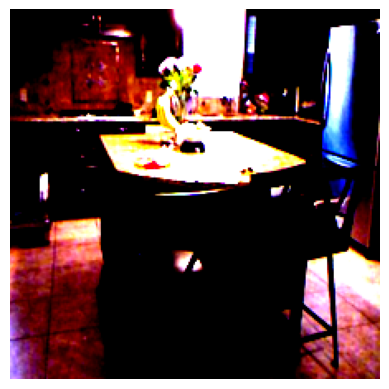

In [78]:
import matplotlib.pyplot as plt

sample_index = 10 
sample_image, sample_questions, sample_labels = train_dataset[sample_index]
sample_image_np = sample_image.permute(1, 2, 0).numpy()
plt.imshow(sample_image_np)
plt.axis('off')
plt.show()



In [22]:

print("Questions:")
for question_idx in sample_questions:
    question_text = idx_2_word.get(question_idx.item(), "UNKNOWN_WORD")
    if question_text == "UNKNOWN_WORD":
            continue
    print(question_text)

print("Labels:")
for label_idx in range(len(sample_labels)):
    if sample_labels[label_idx] == 1:
        label_text = idx_2_answer.get(label_idx, "UNKNOWN_ANSWER")
        if label_text == "UNKNOWN_ANSWER":
            continue
        print(label_text)
label_test = label_text

Questions:
what
is
found
on
the
right
side
Labels:
refridgerator


In [23]:
max_iterations = len(train_ds)

In [24]:
from tqdm import tqdm

In [25]:
log = {
    'train': {
        'loss': []
    },
    'val': {
        'loss': [],
        'wups': [],
        'accuracy-top1': [],
        'accuracy-top5': []
    }
}

### Training Configuration

This section defines the configuration parameters for training the model.

- Number of Epochs: 10
- Initial Learning Rate: 1e-5


In [26]:
epochs = 10
initial_lr = 1e-5

### Optimization and Learning Rate Scheduling

The optimization algorithm and learning rate scheduling strategy are configured as follows:

- Optimizer: Adam optimizer is used with a learning rate of `initial_lr`.
- Loss Function: Cross-entropy loss is employed for computing the loss.
- Learning Rate Scheduler: Exponential decay scheduler is applied to adjust the learning rate during training. The scheduler reduces the learning rate by a factor of 0.9 every `steps_to_reschedule` epochs.


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
steps_to_reschedule = 10

### Training Loop with Optimization and Evaluation

The training loop includes optimization steps, learning rate scheduling, and evaluation. Here's a summary of the process:

- **Optimization**: The model is trained using the Adam optimizer with a learning rate of `initial_lr`.
- **Loss Function**: Cross-entropy loss is calculated to measure the difference between predicted and actual answers.
- **Learning Rate Scheduling**: An Exponential decay scheduler is employed to adjust the learning rate periodically during training. The learning rate is decreased by a factor of 0.9 every `steps_to_reschedule` epochs.
- **Checkpoint Saving**: A checkpoint of the model's state is saved whenever the validation loss improves.
- **Logging**: Training and validation losses, as well as validation accuracy, are logged for each epoch.


In [28]:
current_loss = 999999

effective = 'effective.pth'
last_epoch = 'last.pth'

for epoch in range(epochs):
    model.train()
    train_loss = []
    for i, (images, questions, answers) in tqdm(enumerate(train_ds), total = max_iterations):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        optimizer.zero_grad()    
        output = model(images, questions)

        loss = loss_fn(output, answers)
        loss.backward()

        optimizer.step()
        train_loss.append(loss.data.item())
    
    if epoch % steps_to_reschedule == steps_to_reschedule - 1:
        scheduler.step()
    
    model.eval()
    total_correct, totals, valid_loss, total_wups = 0, 0, [], 0
    for i, (images, questions, answers) in tqdm(enumerate(val_ds)):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        output = model(images, questions)
        
        
        loss = loss_fn(output, answers)
        
        total_correct += (torch.max(output.data, 1)[1] == torch.max(answers.data, 1)[1]).float().sum()
        totals += answers.shape[0]
        valid_loss.append(loss.data.item())
        
    log['train']['loss'].append(torch.mean(torch.Tensor(train_loss)).item())
    
    val_loss = torch.mean(torch.Tensor(train_loss)).item()

    if val_loss < current_loss:
        current_loss = val_loss
        print('Save a checkpoint at epoch: ', epoch)
        torch.save(model.state_dict(), effective)
    
    log['val']['loss'].append(val_loss)
    log['val']['accuracy-top1'].append(total_correct / totals)
    
    print(f'Epoch {epoch} - training loss {log["train"]["loss"][-1]} - validation loss {log["val"]["loss"][-1]} - validation accuracy {log["val"]["accuracy-top1"][-1]}')

100%|██████████| 312/312 [01:40<00:00,  3.11it/s]
78it [00:20,  3.85it/s]


Save a checkpoint at epoch:  0
Epoch 0 - training loss 6.182550430297852 - validation loss 6.182550430297852 - validation accuracy 0.14915797114372253


100%|██████████| 312/312 [01:33<00:00,  3.34it/s]
78it [00:19,  3.97it/s]


Save a checkpoint at epoch:  1
Epoch 1 - training loss 4.995111465454102 - validation loss 4.995111465454102 - validation accuracy 0.19647152721881866


100%|██████████| 312/312 [01:34<00:00,  3.32it/s]
78it [00:19,  3.95it/s]


Save a checkpoint at epoch:  2
Epoch 2 - training loss 4.474329471588135 - validation loss 4.474329471588135 - validation accuracy 0.2253408133983612


100%|██████████| 312/312 [01:33<00:00,  3.34it/s]
78it [00:19,  3.97it/s]


Save a checkpoint at epoch:  3
Epoch 3 - training loss 4.092891693115234 - validation loss 4.092891693115234 - validation accuracy 0.25741779804229736


100%|██████████| 312/312 [01:33<00:00,  3.34it/s]
78it [00:20,  3.85it/s]


Save a checkpoint at epoch:  4
Epoch 4 - training loss 3.724163770675659 - validation loss 3.724163770675659 - validation accuracy 0.2630312740802765


100%|██████████| 312/312 [01:32<00:00,  3.38it/s]
78it [00:19,  4.03it/s]


Save a checkpoint at epoch:  5
Epoch 5 - training loss 3.401540517807007 - validation loss 3.401540517807007 - validation accuracy 0.2902967035770416


100%|██████████| 312/312 [01:34<00:00,  3.32it/s]
78it [00:19,  4.00it/s]


Save a checkpoint at epoch:  6
Epoch 6 - training loss 3.0607738494873047 - validation loss 3.0607738494873047 - validation accuracy 0.2914995849132538


100%|██████████| 312/312 [01:34<00:00,  3.32it/s]
78it [00:19,  3.91it/s]


Save a checkpoint at epoch:  7
Epoch 7 - training loss 2.7508468627929688 - validation loss 2.7508468627929688 - validation accuracy 0.2854851484298706


100%|██████████| 312/312 [01:33<00:00,  3.33it/s]
78it [00:19,  4.04it/s]


Save a checkpoint at epoch:  8
Epoch 8 - training loss 2.483198404312134 - validation loss 2.483198404312134 - validation accuracy 0.2939053773880005


100%|██████████| 312/312 [01:33<00:00,  3.34it/s]
78it [00:19,  3.94it/s]


Save a checkpoint at epoch:  9
Epoch 9 - training loss 2.225921392440796 - validation loss 2.225921392440796 - validation accuracy 0.2862870991230011


### Model Inference and Visualization

This code block performs inference on a few samples from the validation dataset using the trained model and visualizes the results. Here's what it does:

- **Device Selection**: The code checks if a CUDA-compatible GPU is available and sets the device accordingly.
- **Output to Answer Conversion**: A function is defined to convert the model output to a human-readable predicted answer.
- **Visualization**: Samples from the validation dataset are iterated over, and for each sample:
  - The image, question, actual answer, and predicted answer are extracted.
  - The image and relevant text information are displayed in a subplot.
  - Subplots are arranged in a grid layout for visualization.


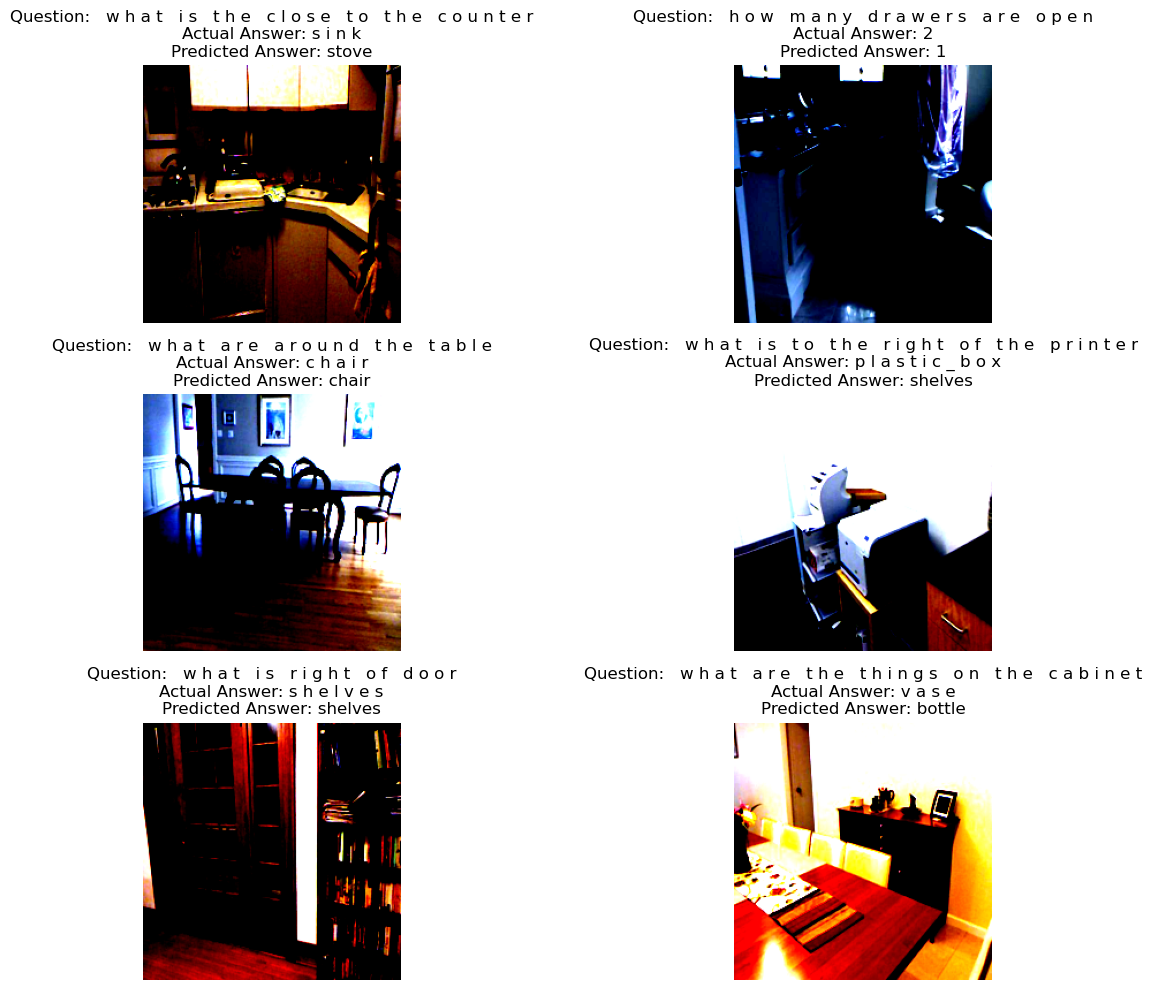

In [29]:
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def output_to_answer(output):
    _, predicted_idx = torch.max(output, -1)
    predicted_answer = idx_2_answer.get(predicted_idx.item(), "UNKNOWN_ANSWER")
    return predicted_answer

num_rows = 3
num_cols = 2

num_samples = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, (images, questions, answers) in enumerate(val_ds):
    if i == num_samples:
        break
    
    images = images.to(device)
    questions = questions.to(device)
    
    outputs = model(images, questions)
    image_np = images.cpu().numpy()[0].transpose(1, 2, 0)
    
    question_text = ''
    for question_idx in questions[0]:
        q_text = idx_2_word.get(question_idx.item(), "UNKNOWN_WORD")
        if q_text == "UNKNOWN_WORD":
            continue
        question_text += ' '+q_text
    
    actual_answer_indices = [idx for idx, val in enumerate(answers[0]) if val == 1]
    actual_answer = [idx_2_answer.get(idx, "UNKNOWN_ANSWER") for idx in actual_answer_indices][0]
    predicted_answer = output_to_answer(outputs[0])
    
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    ax = axes[row_idx, col_idx]
    ax.imshow(image_np)
    ax.axis('off')
    ax.set_title(f"Question: {' '.join(question_text)}\nActual Answer: {' '.join(actual_answer)}\nPredicted Answer: {predicted_answer}")

plt.tight_layout()
plt.show()


### Training and Validation Performance Analysis

This code block plots the training and validation loss over epochs, as well as the validation accuracy.

- **Training Loss Plot**: Shows how the training loss changes over epochs. Lower values indicate better model performance on the training dataset.
- **Validation Loss Plot**: Indicates how well the model generalizes to unseen data by plotting the validation loss over epochs. Similar to the training loss, lower values are desirable.
- **Validation Accuracy Plot**: Illustrates the accuracy of the model predictions on the validation dataset across epochs. Higher values represent better model performance.


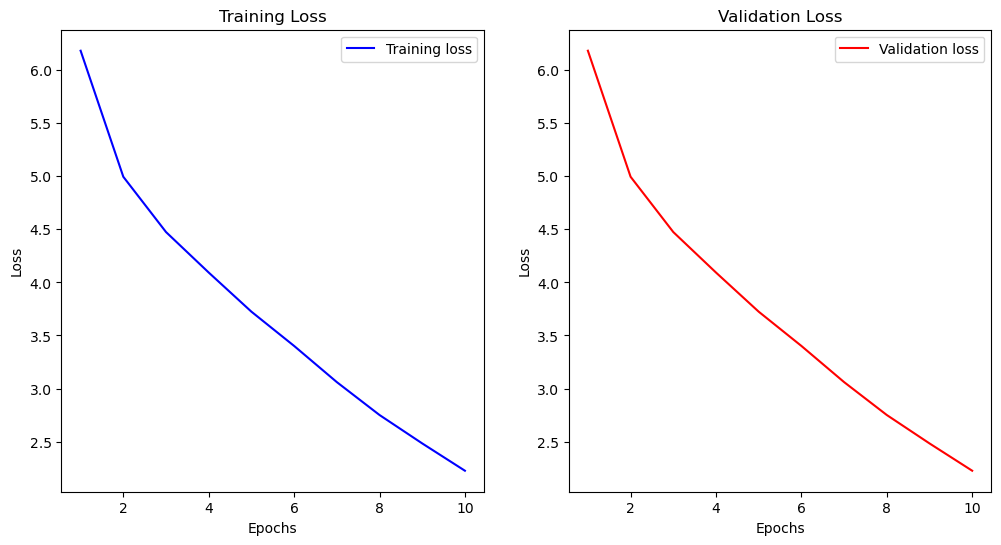

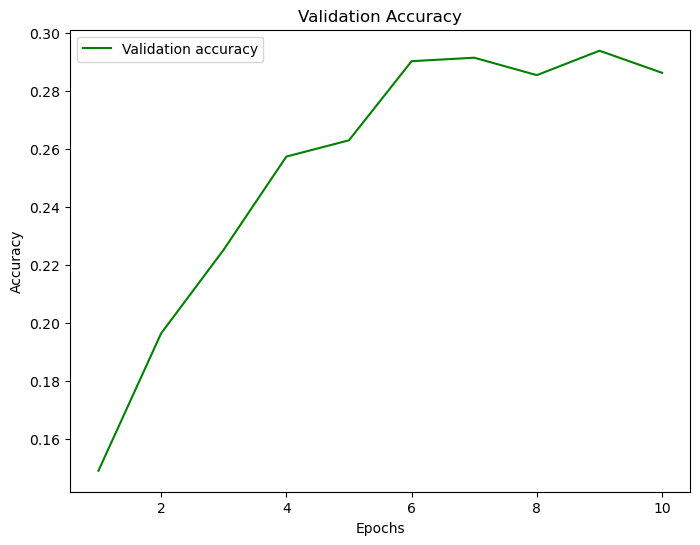

In [30]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = log['train']['loss']
val_loss = log['val']['loss']
val_accuracy = [acc.cpu().numpy() for acc in log['val']['accuracy-top1']]  # Convert tensors to numpy arrays

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [31]:
print('Saving model to', last_epoch)
torch.save(model.state_dict(), last_epoch)

Saving model to last.pth


### Acknowledgments

We extend our gratitude to the numerous sources and contributors whose work has been invaluable in the development of this project. While it's not feasible to name each one individually, we acknowledge the collective efforts of researchers, educators, developers, and open-source communities whose work has laid the foundation for our endeavors. We are indebted to the wealth of knowledge shared through research papers, online forums, tutorials, and code repositories, which have guided and inspired our work.

Lastly, we thank our colleagues, mentors, and peers for their support, feedback, and collaboration throughout this journey. Their insights and encouragement have been instrumental in shaping our ideas and refining our approaches.